# Use a standard dataset for this example

In [1]:
import arviz as az
import numpy as np  # For vectorized math operations
import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
plt.rcParams["font.family"] = "Latin Modern Roman"

rng = np.random.default_rng(42)

In [3]:
try:
    wide_heating_df = pd.read_csv("../data/heating_data_r.csv")
except:
    wide_heating_df = pd.read_csv(pm.get_data("heating_data_r.csv"))

wide_heating_df[wide_heating_df["idcase"] == 1]

In [4]:
# pivoted data that is more amenable to analysis
 
try:
    long_heating_df = pd.read_csv("../data/long_heating_data.csv")
except:
    long_heating_df = pd.read_csv(pm.get_data("long_heating_data.csv"))

columns = [c for c in long_heating_df.columns if c != "Unnamed: 0"]
long_heating_df[long_heating_df["idcase"] == 1][columns]

In [5]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes
coords = {
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}

with pm.Model(coords=coords) as model_1:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)

    ## Construct Utility matrix and Pivot
    u0 = beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=101)
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

pm.model_to_graphviz(model_1)

Sampling: [beta_ic, beta_oc, y_cat]

Sampling: [y_cat]

In [6]:
idata_m1

arviz.InferenceData 
 
 
 
 
 
 posterior 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset> Size: 144MB
Dimensions: (chain: 4, draw: 1000, obs: 900, alts_probs: 5)
Coordinates:
 * chain (chain) int64 32B 0 1 2 3
 * draw (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
 * obs (obs) int64 7kB 0 1 2 3 4 5 6 7 ... 893 894 895 896 897 898 899
 * alts_probs (alts_probs) <U2 40B 'ec' 'er' 'gc' 'gr' 'hp'
Data variables:
 beta_ic (chain, draw) float64 32kB 0.001832 0.001817 ... 0.001948
 beta_oc (chain, draw) float64 32kB -0.003705 -0.003709 ... -0.004581
 p (chain, draw, obs, alts_probs) float64 144MB 0.07556 ... 0.1102
Attributes:
 created_at: 2024-06-23T20:32:15.207517+00:00
 arviz_version: 0.18.0 xarray.Dataset Dimensions: chain : 4 draw : 1000 obs : 900 alts_probs : 5 Coordinates: (4) chain (chain) int64 0 1 2 3 array([0, 1, 2, 3]) draw (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999 array([ 0, 1, 2, ..., 997, 998, 999]) obs (obs) int64 0 1 2 3 4 5 ... 895 896 897 898 899 array([ 0, 1, 2, ..., 897, 898, 899]) alts_probs (alts_probs) <U2 'ec' 'er' 'gc' 'gr' 'hp' array(['ec', 'er', 'gc', 'gr', 'hp'], dtype='<U2') Data variables: (3) beta_ic (chain, draw) float64 0.001832 0.001817 ... 0.001948 array([[0.00183239, 0.00181733, 0.00180854, ..., 0.00181192, 0.00175778,
 0.00210304],
 [0.00210654, 0.00210654, 0.00197494, ..., 0.0019049 , 0.00187513,
 0.00181919],
 [0.00181312, 0.00179163, 0.00173467, ..., 0.002031 , 0.00212423,
 0.00171305],
 [0.00185484, 0.00177189, 0.00187684, ..., 0.00206325, 0.00207469,
 0.00194822]]) beta_oc (chain, draw) float64 -0.003705 -0.003709 ... -0.004581 array([[-0.00370539, -0.00370935, -0.00431479, ..., -0.00461288,
 -0.00460595, -0.00406624],
 [-0.00443282, -0.00443282, -0.00414015, ..., -0.00426425,
 -0.00412309, -0.0040975 ],
 [-0.00395141, -0.00370944, -0.00377519, ..., -0.0049641 ,
 -0.00476948, -0.0036491 ],
 [-0.00381868, -0.00404807, -0.00393956, ..., -0.0042988 ,
 -0.00462425, -0.00458066]]) p (chain, draw, obs, alts_probs) float64 0.07556 0.1157 ... 0.428 0.1102 array([[[[0.07556231, 0.115677 , 0.28331138, 0.4039845 , 0.1214648 ],
 [0.09409705, 0.12757696, 0.30515943, 0.32297186, 0.15019469],
 [0.10440213, 0.16496078, 0.23067664, 0.3579255 , 0.14203495],
 ...,
 [0.08474306, 0.13638204, 0.23587751, 0.43633533, 0.10666206],
 [0.07042229, 0.18021517, 0.22561794, 0.42184934, 0.10189526],
 [0.08717172, 0.13668048, 0.27121101, 0.40382201, 0.10111478]],

 [[0.07540941, 0.11522867, 0.28310845, 0.40318444, 0.12306902],
 [0.09378437, 0.12698266, 0.30488553, 0.32253151, 0.15181593],
 [0.1041803 , 0.16418621, 0.23085429, 0.35725122, 0.14352798],
 ...,
 [0.08467137, 0.13587604, 0.23615981, 0.43515429, 0.10813849],
 [0.07046016, 0.17950217, 0.22578659, 0.42086267, 0.10338842],
 [0.08701837, 0.13621822, 0.27140404, 0.40272926, 0.10263011]],

 [[0.06122794, 0.0961875 , 0.28473604, 0.41709752, 0.140751 ],
 [0.07754801, 0.10707428, 0.3120934 , 0.3300667 , 0.17321761],
 [0.08971942, 0.14413631, 0.23485909, 0.36901728, 0.1622679 ],
 ...,
...
 ...,
 [0.07148748, 0.12262564, 0.23524756, 0.47222741, 0.09841191],
 [0.05809065, 0.1693353 , 0.22340738, 0.45541326, 0.09375342],
 [0.07380963, 0.12341259, 0.27669202, 0.43293536, 0.0931504 ]],

 [[0.0557185 , 0.09210605, 0.28955146, 0.44171102, 0.12091297],
 [0.07321771, 0.10485256, 0.32256519, 0.34396418, 0.15540036],
 [0.08500087, 0.14479629, 0.23452216, 0.39027898, 0.14540171],
 ...,
 [0.06514664, 0.11311106, 0.2365109 , 0.48142957, 0.10380182],
 [0.05287363, 0.15948594, 0.22320083, 0.4650963 , 0.09934329],
 [0.0669652 , 0.11434375, 0.28043246, 0.43930699, 0.09895161]],

 [[0.05622438, 0.09116917, 0.28748885, 0.43233235, 0.13278524],
 [0.07282079, 0.10284997, 0.31870176, 0.33851648, 0.16711101],
 [0.08500239, 0.14132398, 0.2353021 , 0.38212832, 0.15624321],
 ...,
 [0.06612004, 0.11180751, 0.23856091, 0.46873109, 0.11478046],
 [0.05429461, 0.15656816, 0.22464392, 0.4540332 , 0.11046011],
 [0.06750051, 0.11316997, 0.28109683, 0.4280232 , 0.11020948]]]])

In [7]:
summaries = az.summary(idata_m1, var_names=["beta_ic", "beta_oc"])
summaries # results are sus because beta_ic and beta_oc should both be negative

In [8]:
## marginal rate of substitution for a reduction in installation costs
post = az.extract(idata_m1)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

-2.211196691253724

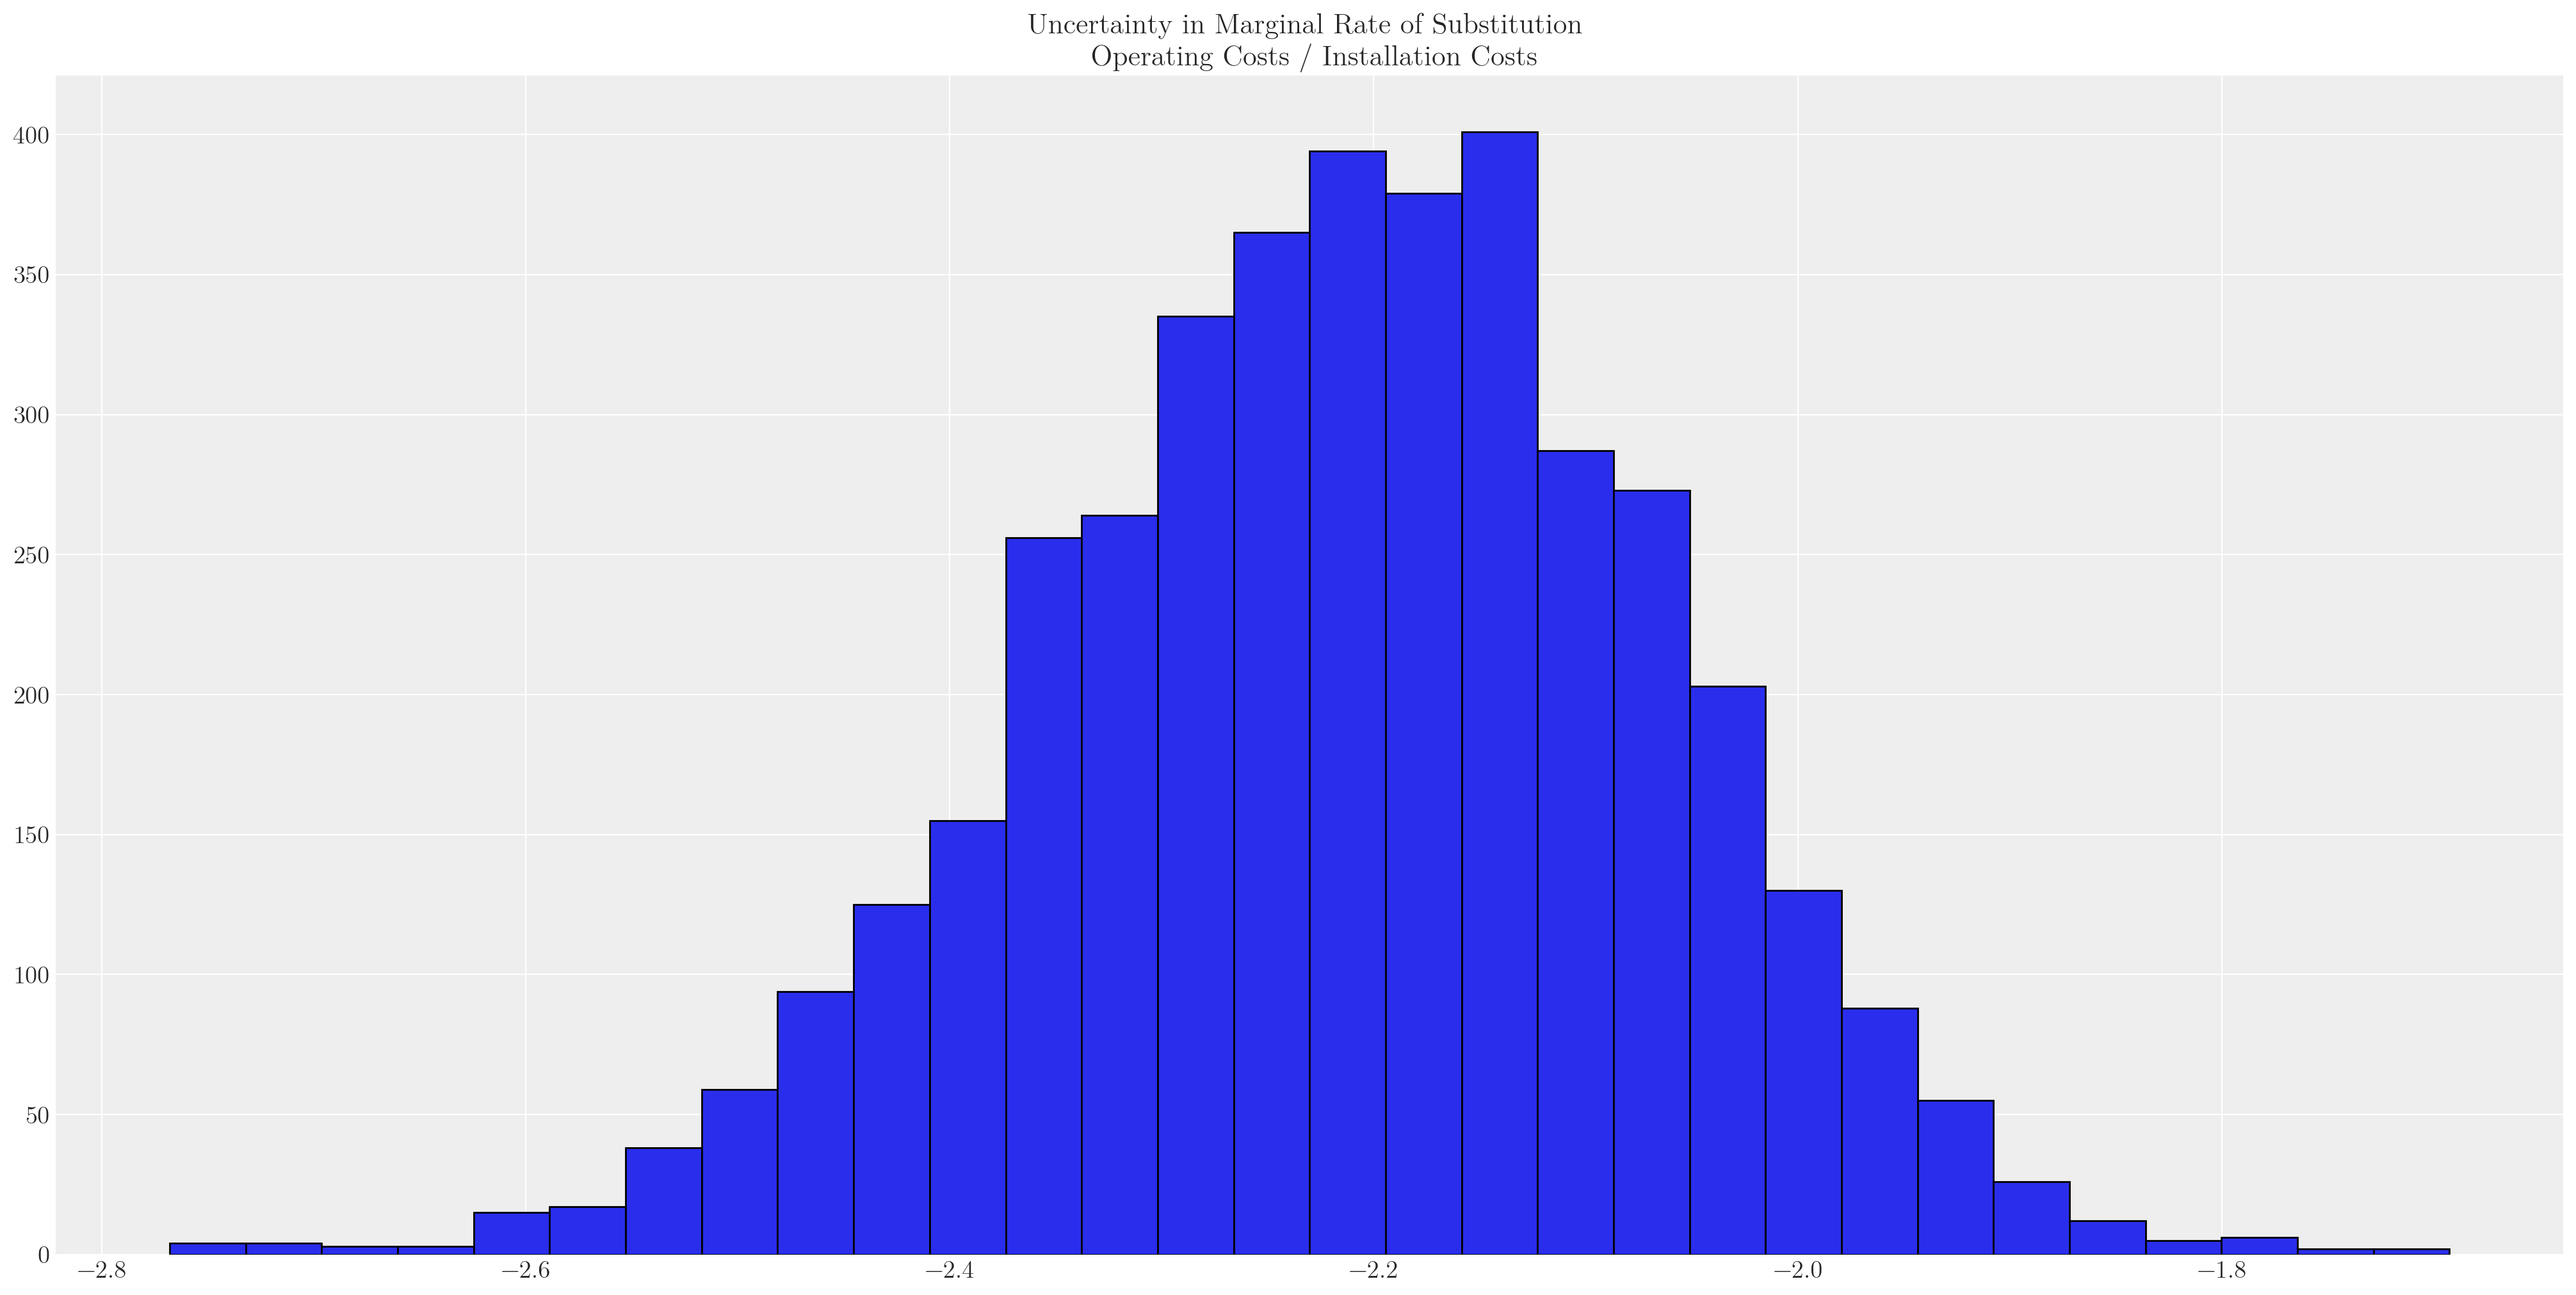

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(
    substitution_rate,
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs");
plt.show()

In [10]:
idata_m1["posterior"]["p"].mean(dim=["chain", "draw", "obs"])

<xarray.DataArray 'p' (alts_probs: 5)> Size: 40B
array([0.08432415, 0.13772203, 0.26912233, 0.38199249, 0.12683901])
Coordinates:
 * alts_probs (alts_probs) <U2 40B 'ec' 'er' 'gc' 'gr' 'hp' xarray.DataArray 'p' alts_probs : 5 0.08432 0.1377 0.2691 0.382 0.1268 array([0.08432415, 0.13772203, 0.26912233, 0.38199249, 0.12683901]) Coordinates: (1) alts_probs (alts_probs) <U2 'ec' 'er' 'gc' 'gr' 'hp' array(['ec', 'er', 'gc', 'gr', 'hp'], dtype='<U2') Indexes: (1) alts_probs PandasIndex PandasIndex(Index(['ec', 'er', 'gc', 'gr', 'hp'], dtype='object', name='alts_probs')) Attributes: (0)

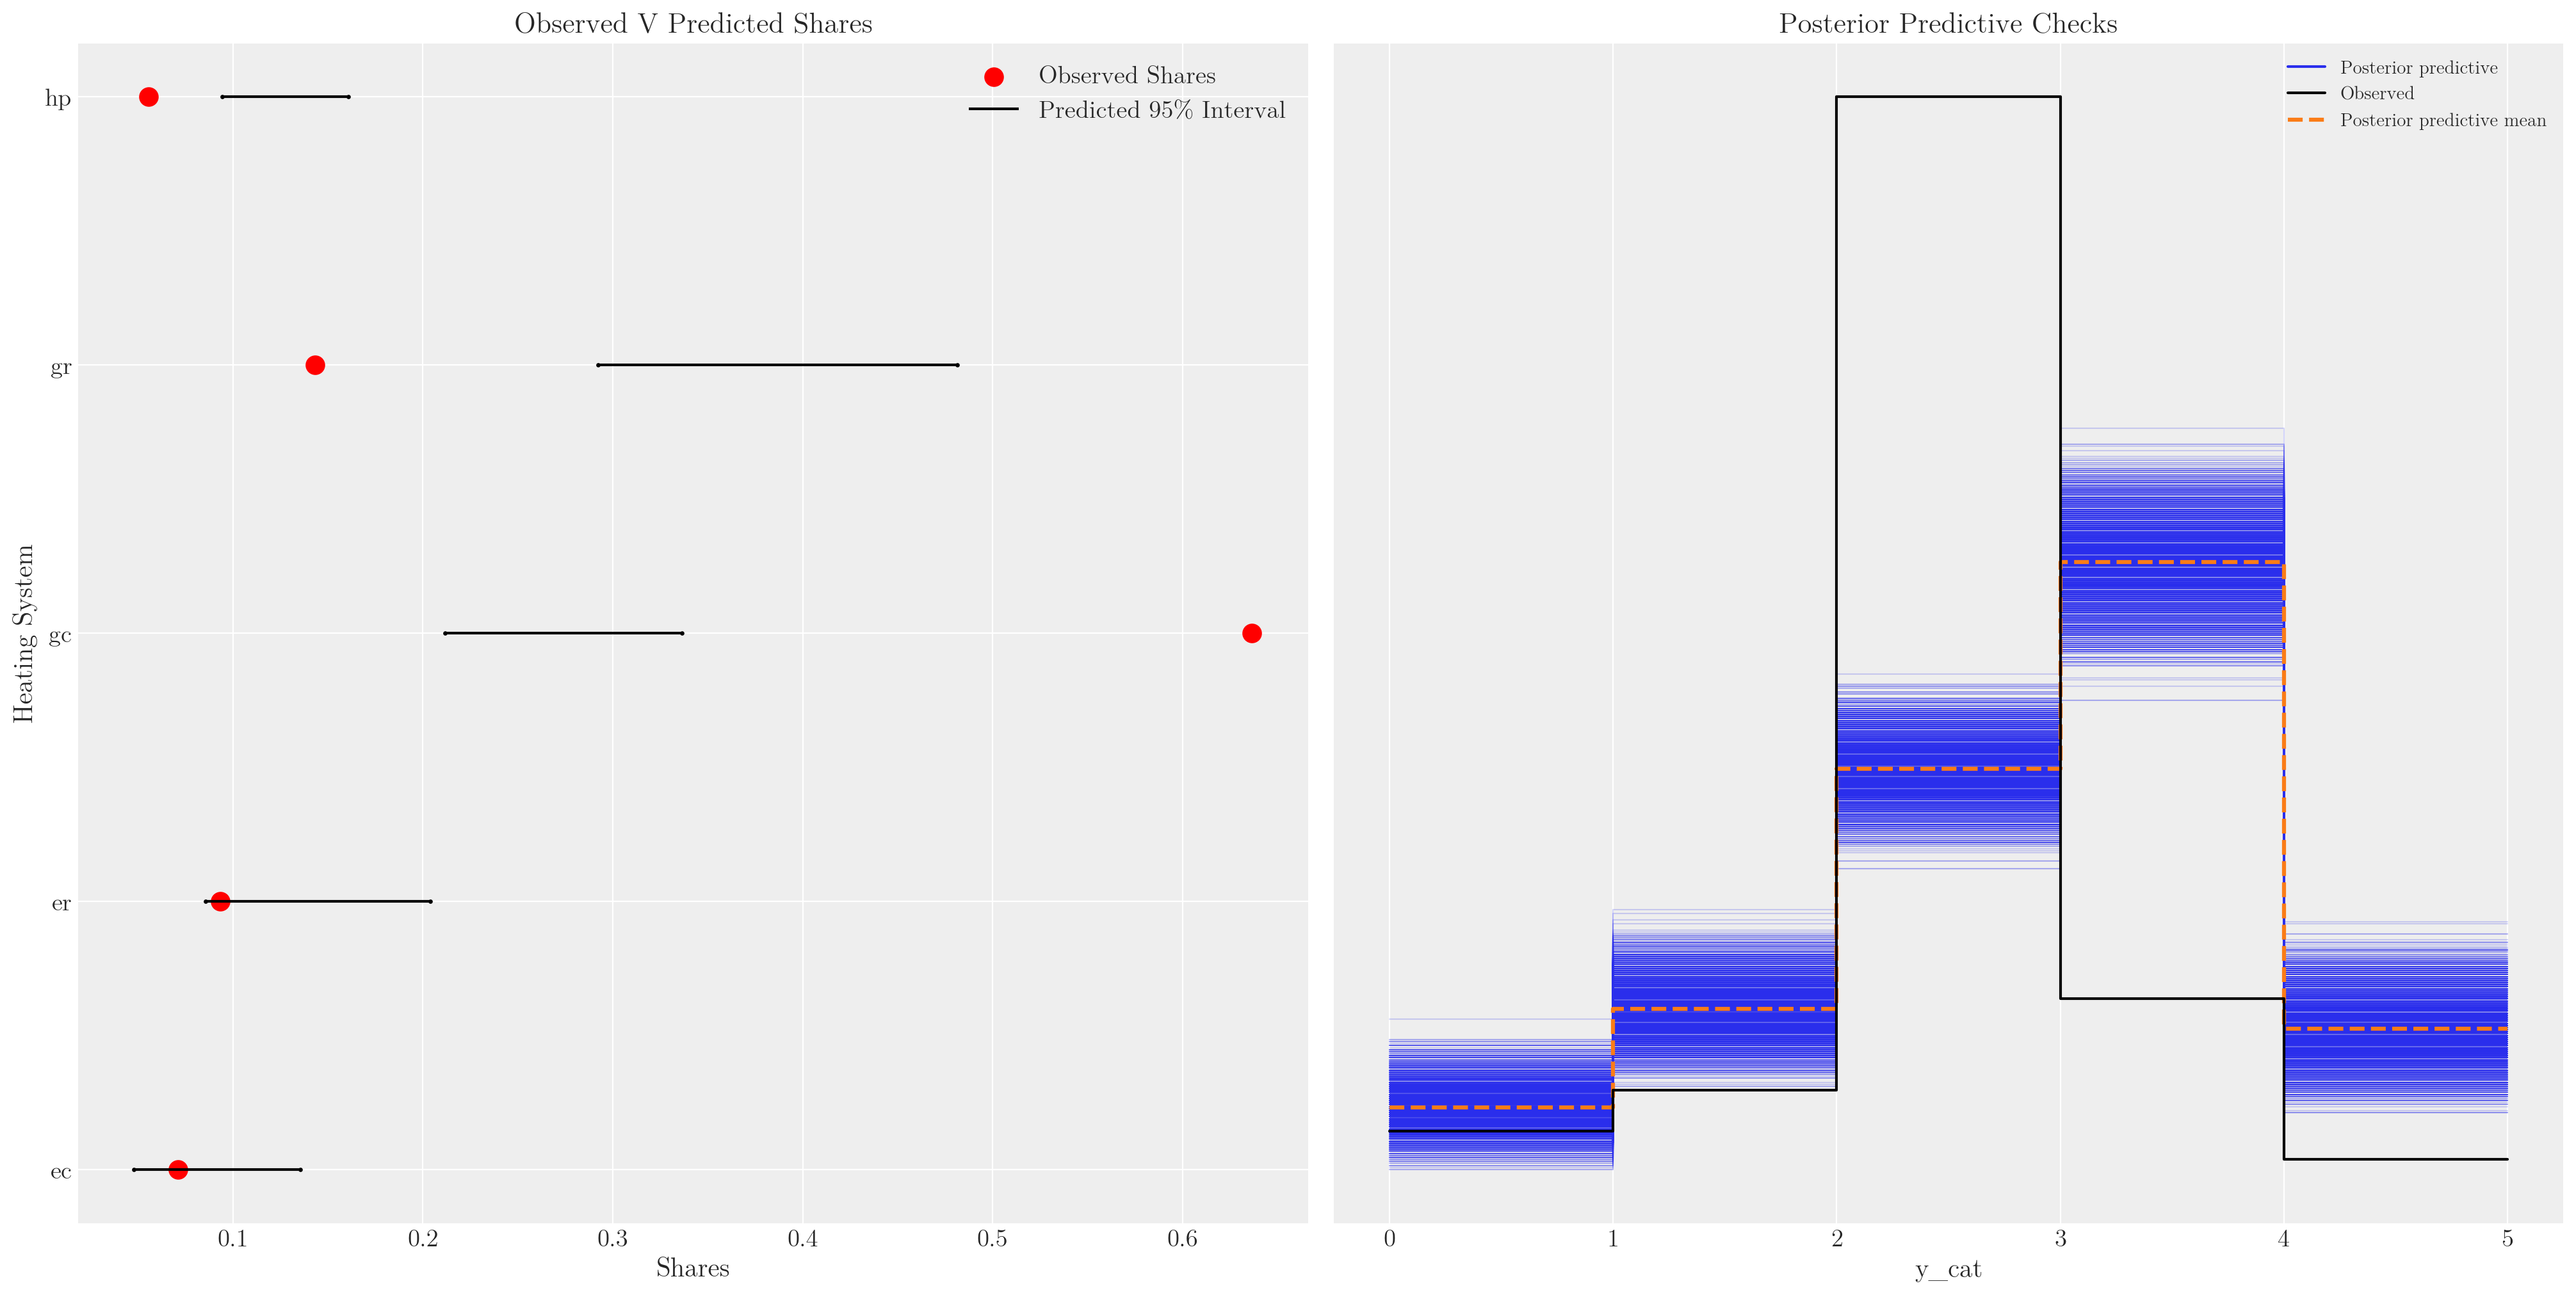

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m1["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m1["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m1["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m1, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

# Getting a better fit

You can improve the fit by adding a good-specific intercept – intuitively this should allow you to match the observed frequencies

In [12]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes

coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_2:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")

    ## Construct Utility matrix and Pivot using an intercept per alternative
    u0 = alphas[0] + beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = alphas[1] + beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = alphas[2] + beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = alphas[3] + beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m2 = pm.sample_prior_predictive()
    idata_m2.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=103)
    )
    idata_m2.extend(pm.sample_posterior_predictive(idata_m2))


pm.model_to_graphviz(model_2)

Sampling: [alpha, beta_ic, beta_oc, y_cat]

Sampling: [y_cat]

In [13]:
az.summary(idata_m2, var_names=["beta_ic", "beta_oc", "alpha"])

# model is still terrible, installation costs and operational costs are meaningless, it's all about the intercepts

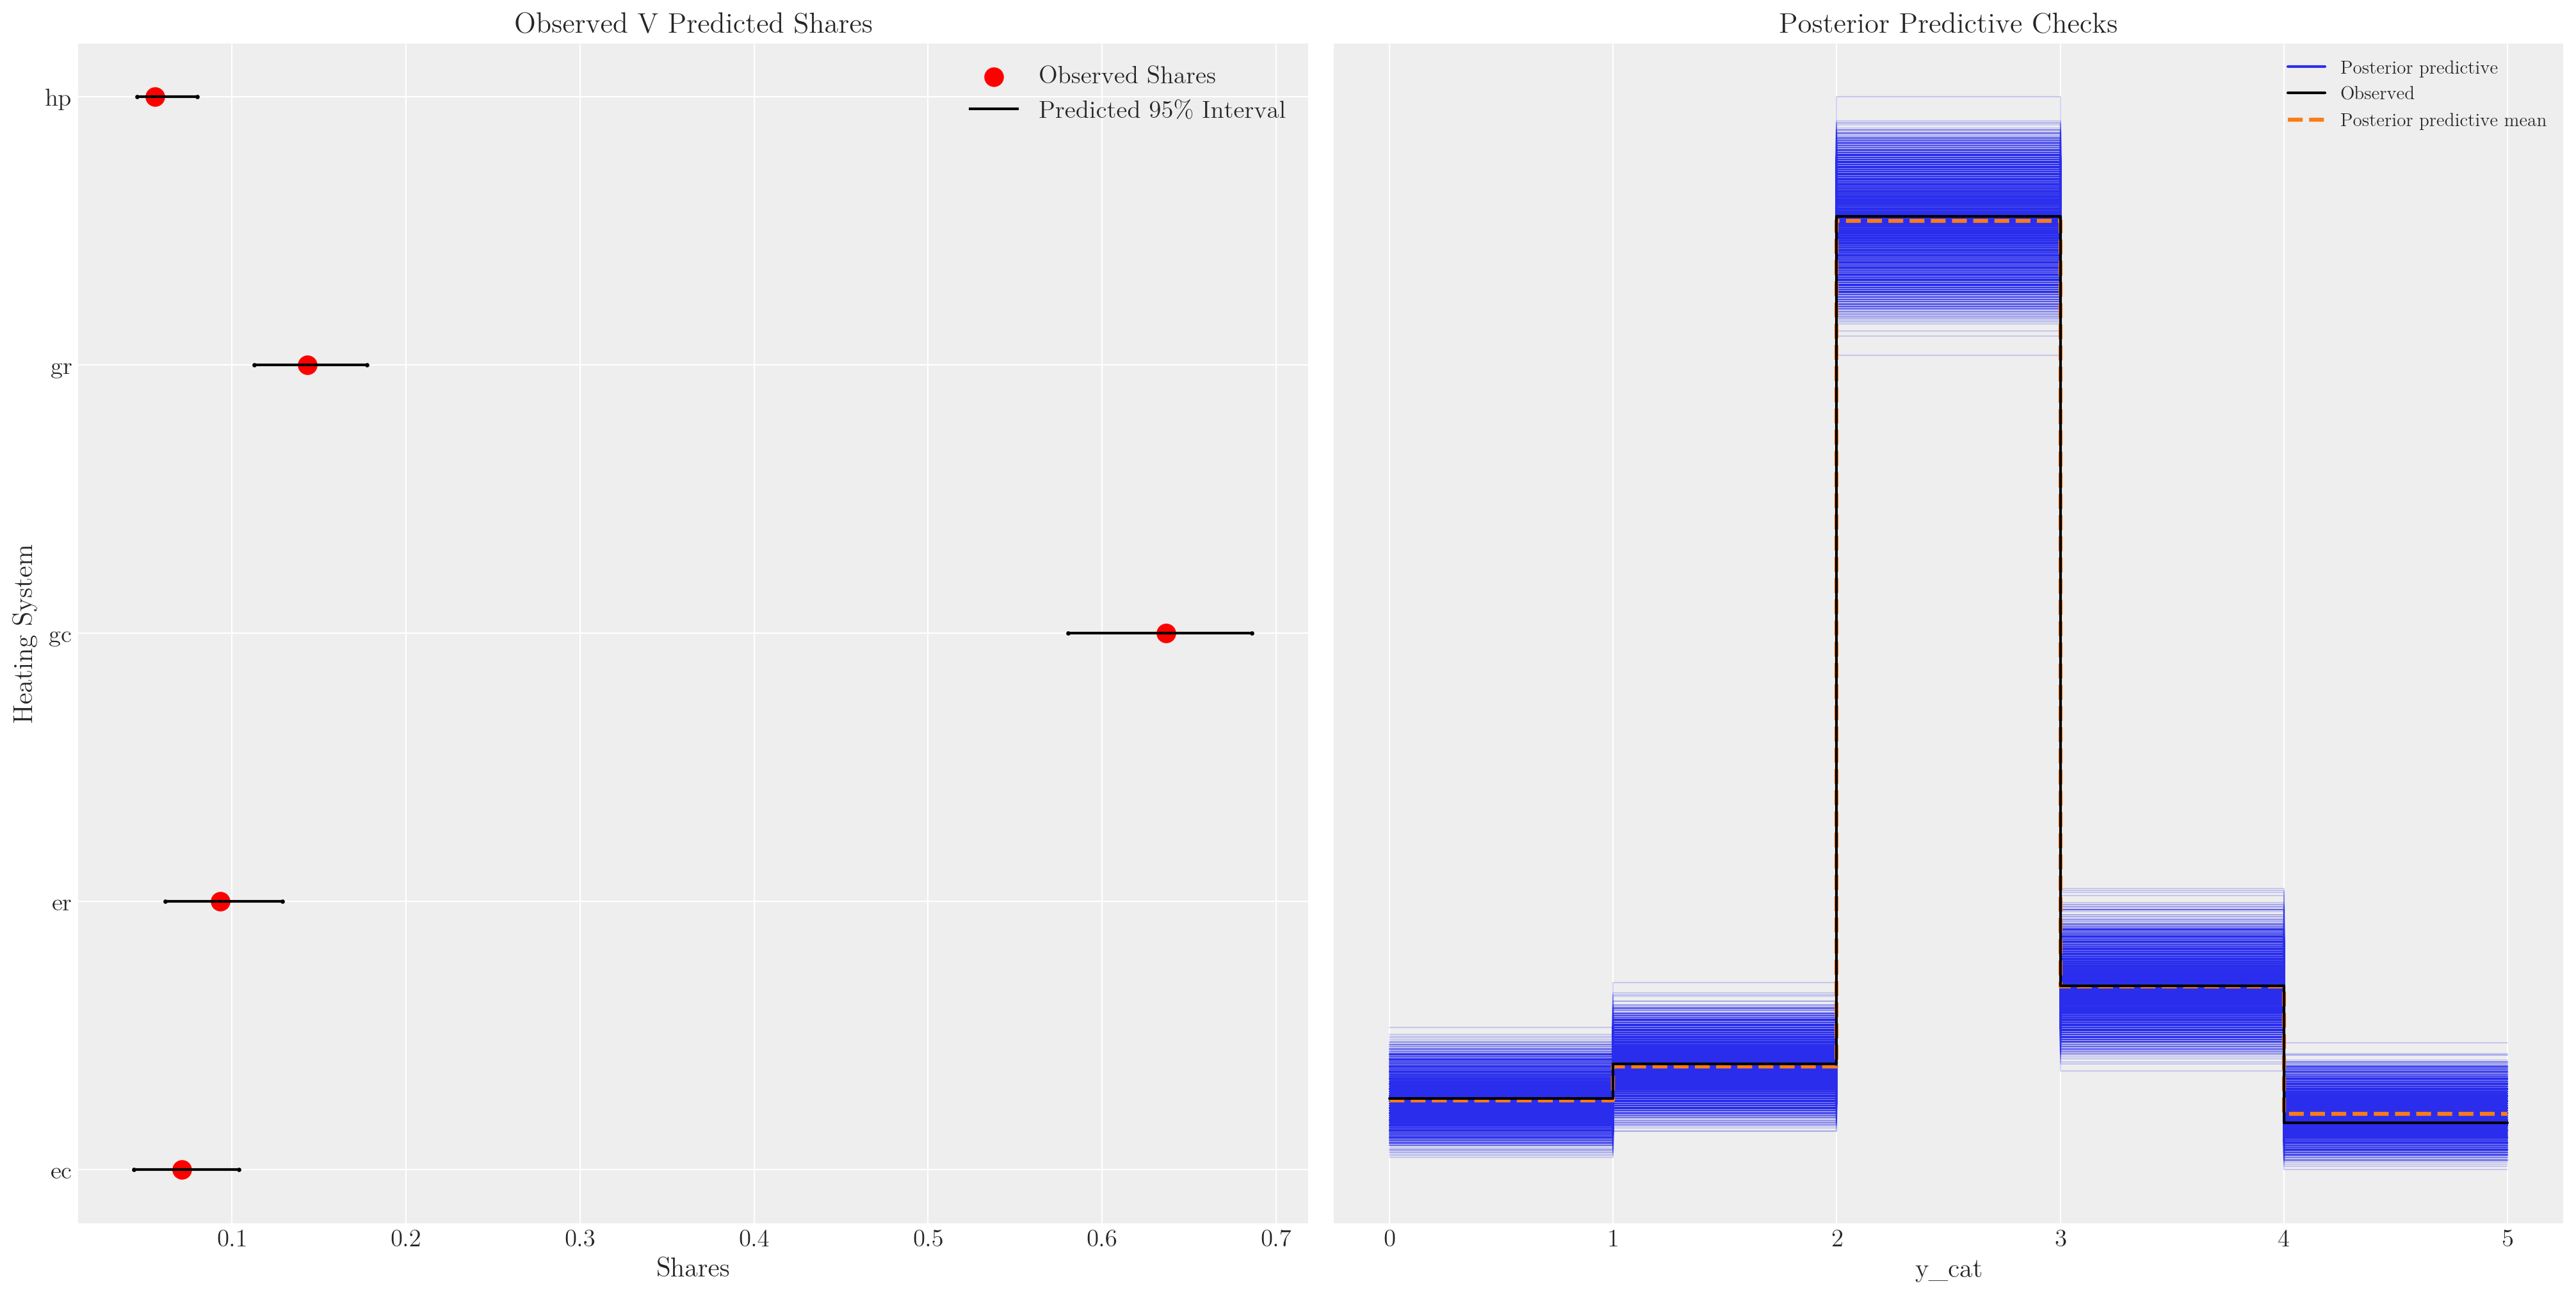

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m2["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m2["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m2["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])

ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m2, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

In [15]:
## marginal rate of substitution for a reduction in installation costs
post = az.extract(idata_m2)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

-11.215830921463027

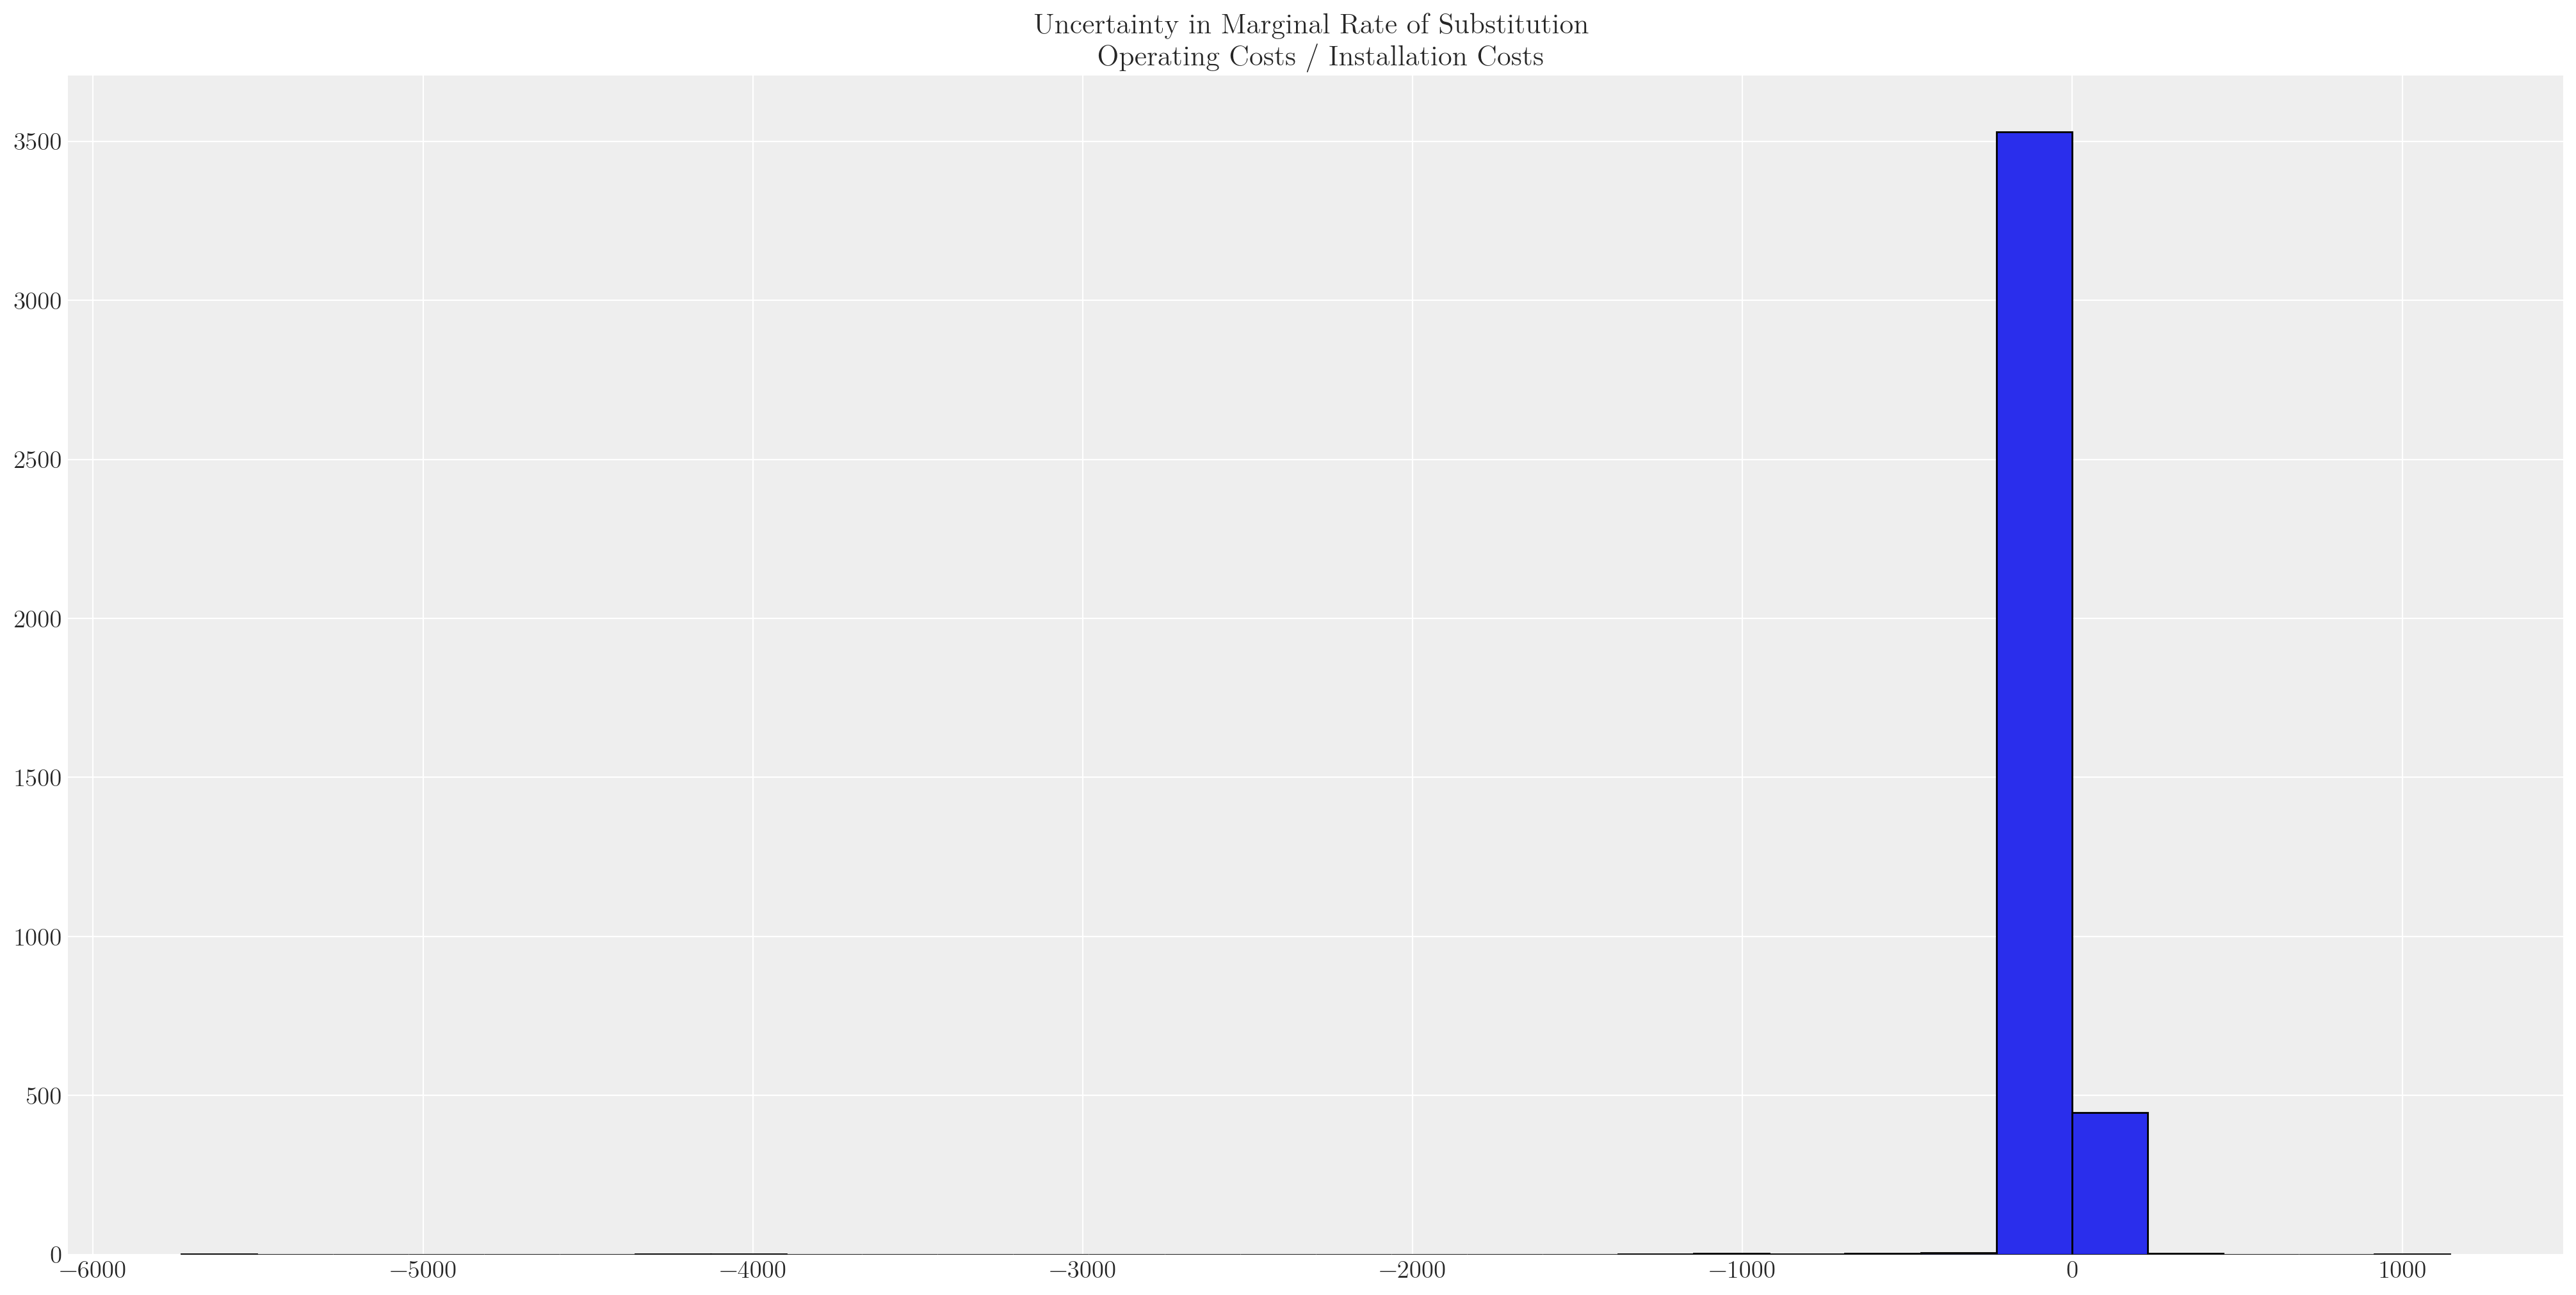

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(
    substitution_rate,
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs");

# Bells and Whistles

Adding some cool extra features by: - using a multivariate normal distirbution – this allows for correlation among alternatives - controlling for income in a log-affine fashion

Intuitively not sure how the correlation is identified, given that you only observe the actual choice

In [17]:
coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_3:
    ## Add data to experiment with changes later.
    ic_ec = pm.Data("ic_ec", wide_heating_df["ic.ec"])
    oc_ec = pm.Data("oc_ec", wide_heating_df["oc.ec"])
    ic_er = pm.Data("ic_er", wide_heating_df["ic.er"])
    oc_er = pm.Data("oc_er", wide_heating_df["oc.er"])

    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    beta_income = pm.Normal("beta_income", 0, 1, dims="alts_intercepts")
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=4, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    alphas = pm.MvNormal("alpha", mu=0, chol=chol, dims="alts_intercepts")

    u0 = alphas[0] + beta_ic * ic_ec + beta_oc * oc_ec + beta_income[0] * wide_heating_df["income"]
    u1 = alphas[1] + beta_ic * ic_er + beta_oc * oc_er + beta_income[1] * wide_heating_df["income"]
    u2 = (
        alphas[2]
        + beta_ic * wide_heating_df["ic.gc"]
        + beta_oc * wide_heating_df["oc.gc"]
        + beta_income[2] * wide_heating_df["income"]
    )
    u3 = (
        alphas[3]
        + beta_ic * wide_heating_df["ic.gr"]
        + beta_oc * wide_heating_df["oc.gr"]
        + beta_income[3] * wide_heating_df["income"]
    )
    u4 = np.zeros(N)  # pivot
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m3 = pm.sample_prior_predictive()
    idata_m3.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=100)
    )
    idata_m3.extend(pm.sample_posterior_predictive(idata_m3))


pm.model_to_graphviz(model_3)

Sampling: [alpha, beta_ic, beta_income, beta_oc, chol, y_cat]

There were 713 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_cat]

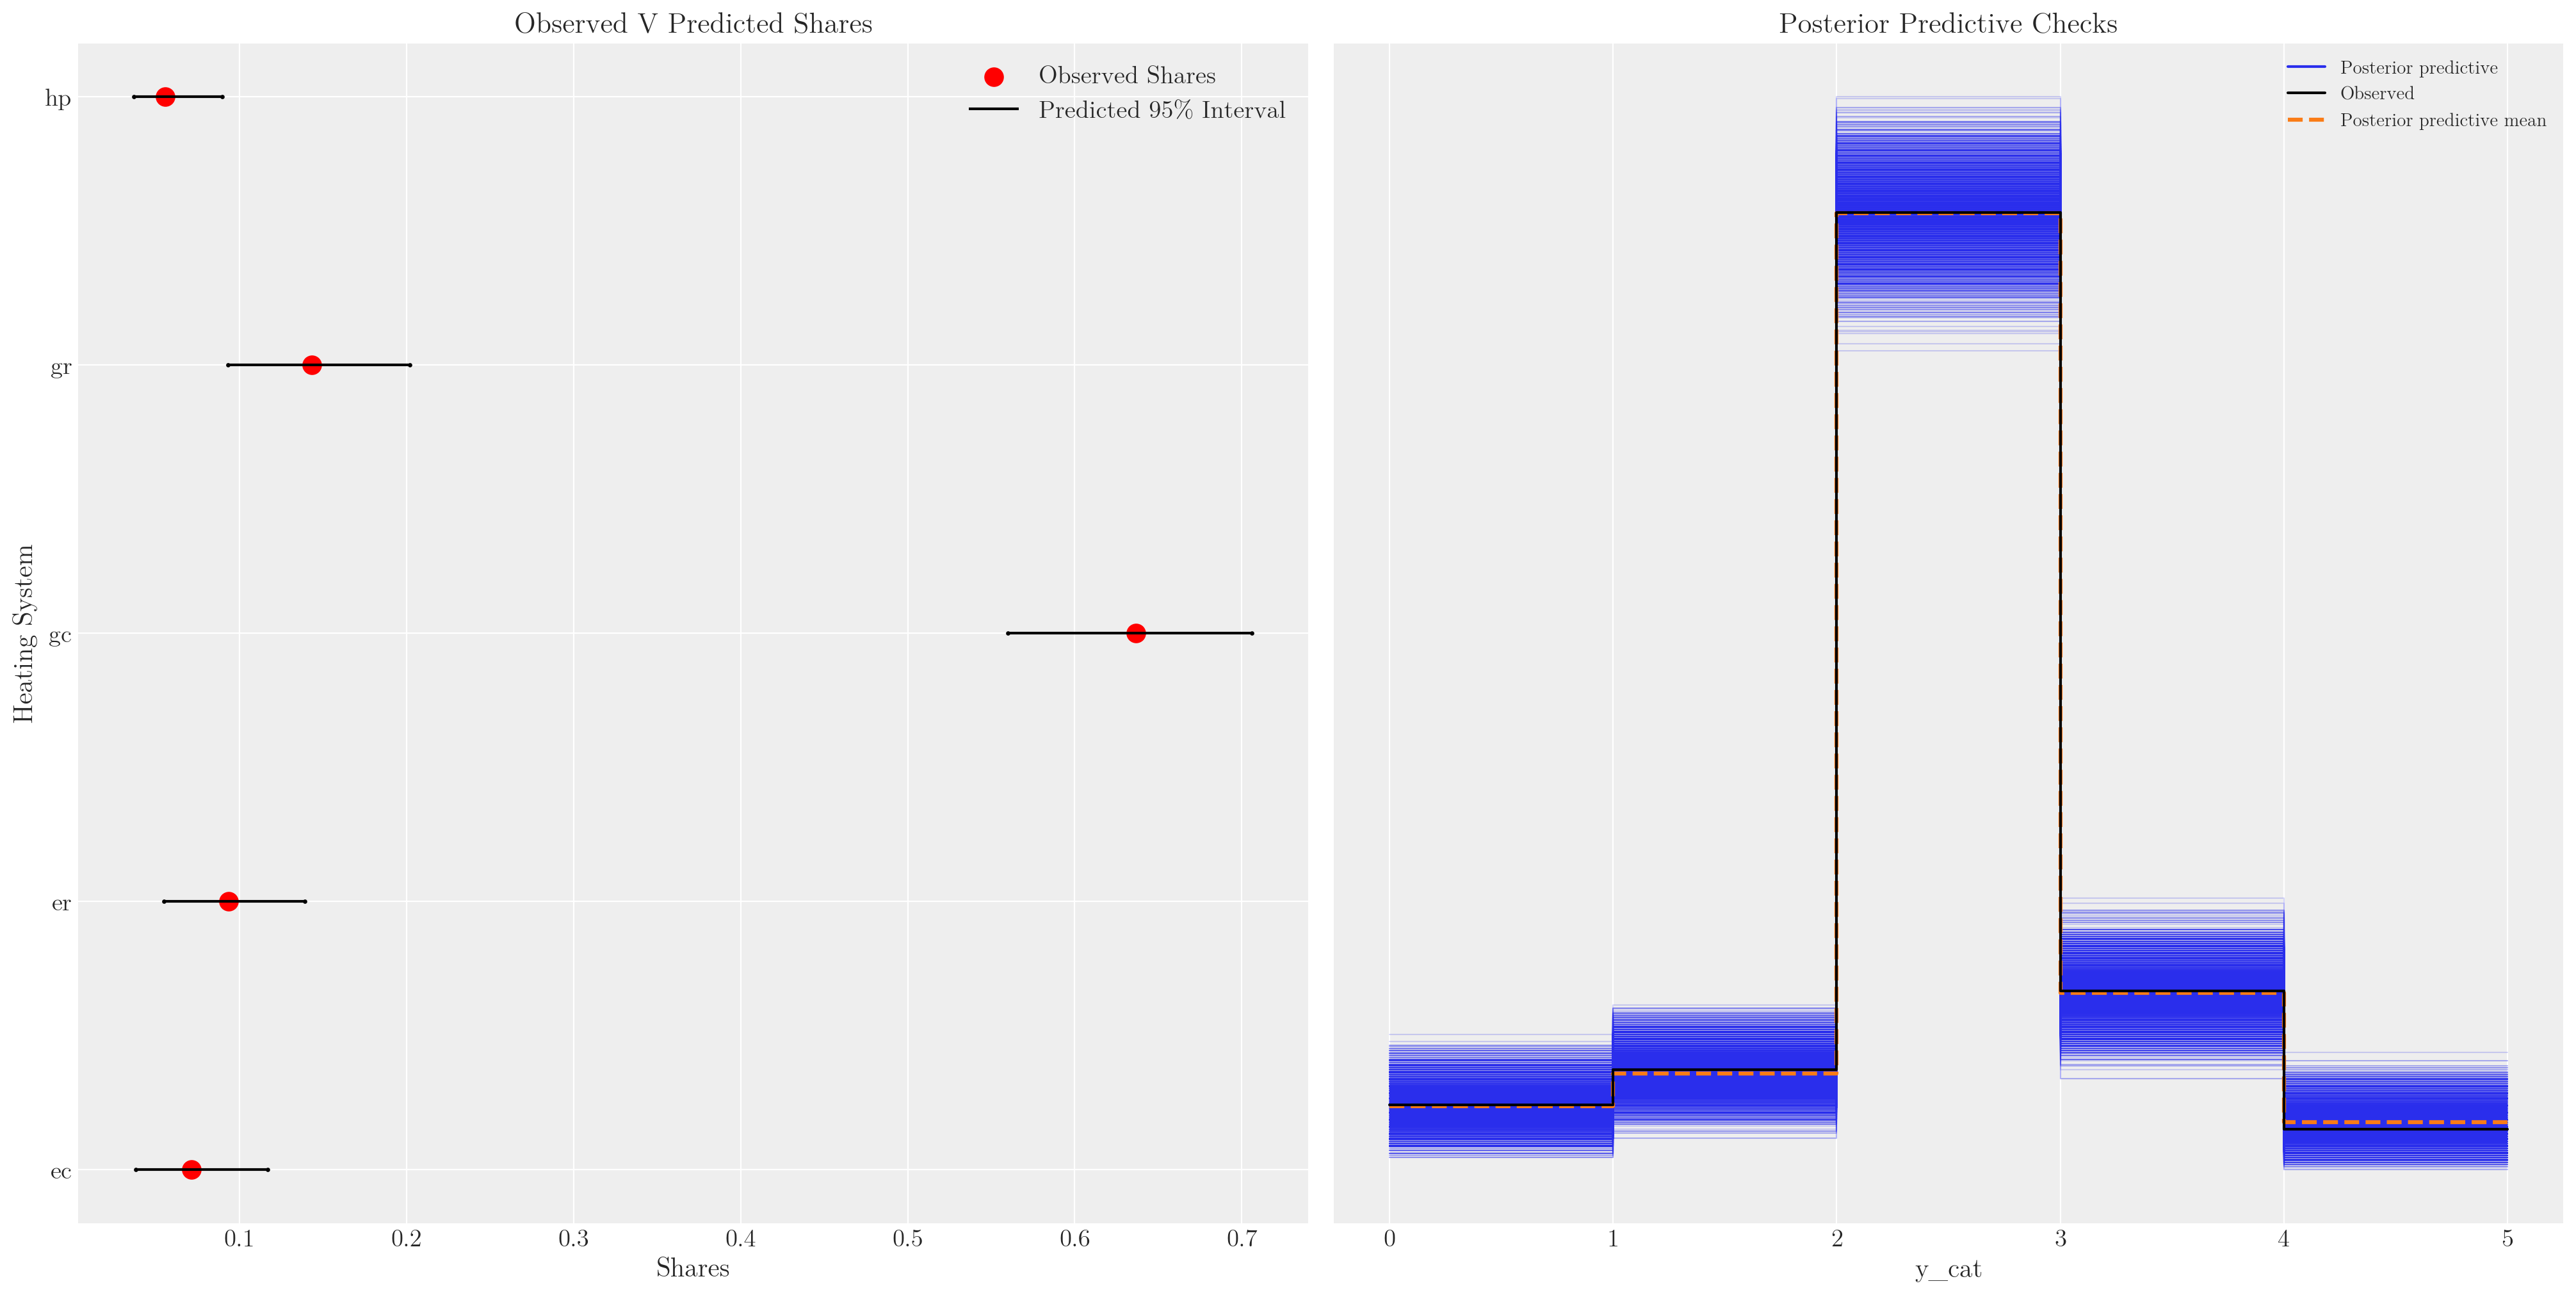

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m3["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m3["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m3["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])

ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m3, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

In [19]:
az.summary(
    idata_m3, var_names=["beta_income", "beta_ic", "beta_oc", "alpha", "chol_corr"], round_to=4
)

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)

In [20]:
post = az.extract(idata_m3)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

-13.242388002273604

# Tweaks

My preferred model is model 2, but with - a control for income - (ideally) set-constrained coefficients for installation cost and operating cost. However, this doesn’t work. In practice it’s because the coefficients are both so small (especially the $\beta_\text{installation cost}$) that constraining it is difficult

Because they’re so small and so close to zero, it’s also not meaningful to talk about a MRS.

In [21]:
coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}

with pm.Model(coords=coords) as model_4:
    beta_ic = pm.Normal("beta_ic")
    beta_oc = pm.Normal("beta_oc")
    beta_income = pm.Normal("beta_income", 0, 1, dims="alts_intercepts")
    alphas = pm.Normal("alpha", 0, 5, dims="alts_intercepts")

    ## Construct Utility matrix and Pivot using an intercept per alternative
    u0 = alphas[0] + beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"] + beta_income[0] * wide_heating_df["income"]
    u1 = alphas[1] + beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"] + beta_income[1] * wide_heating_df["income"]
    u2 = alphas[2] + beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"] + beta_income[2] * wide_heating_df["income"]
    u3 = alphas[3] + beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"] + beta_income[3] * wide_heating_df["income"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m4 = pm.sample_prior_predictive()
    idata_m4.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=100)
    )
    idata_m4.extend(pm.sample_posterior_predictive(idata_m4))


pm.model_to_graphviz(model_4)

Sampling: [alpha, beta_ic, beta_income, beta_oc, y_cat]

Sampling: [y_cat]

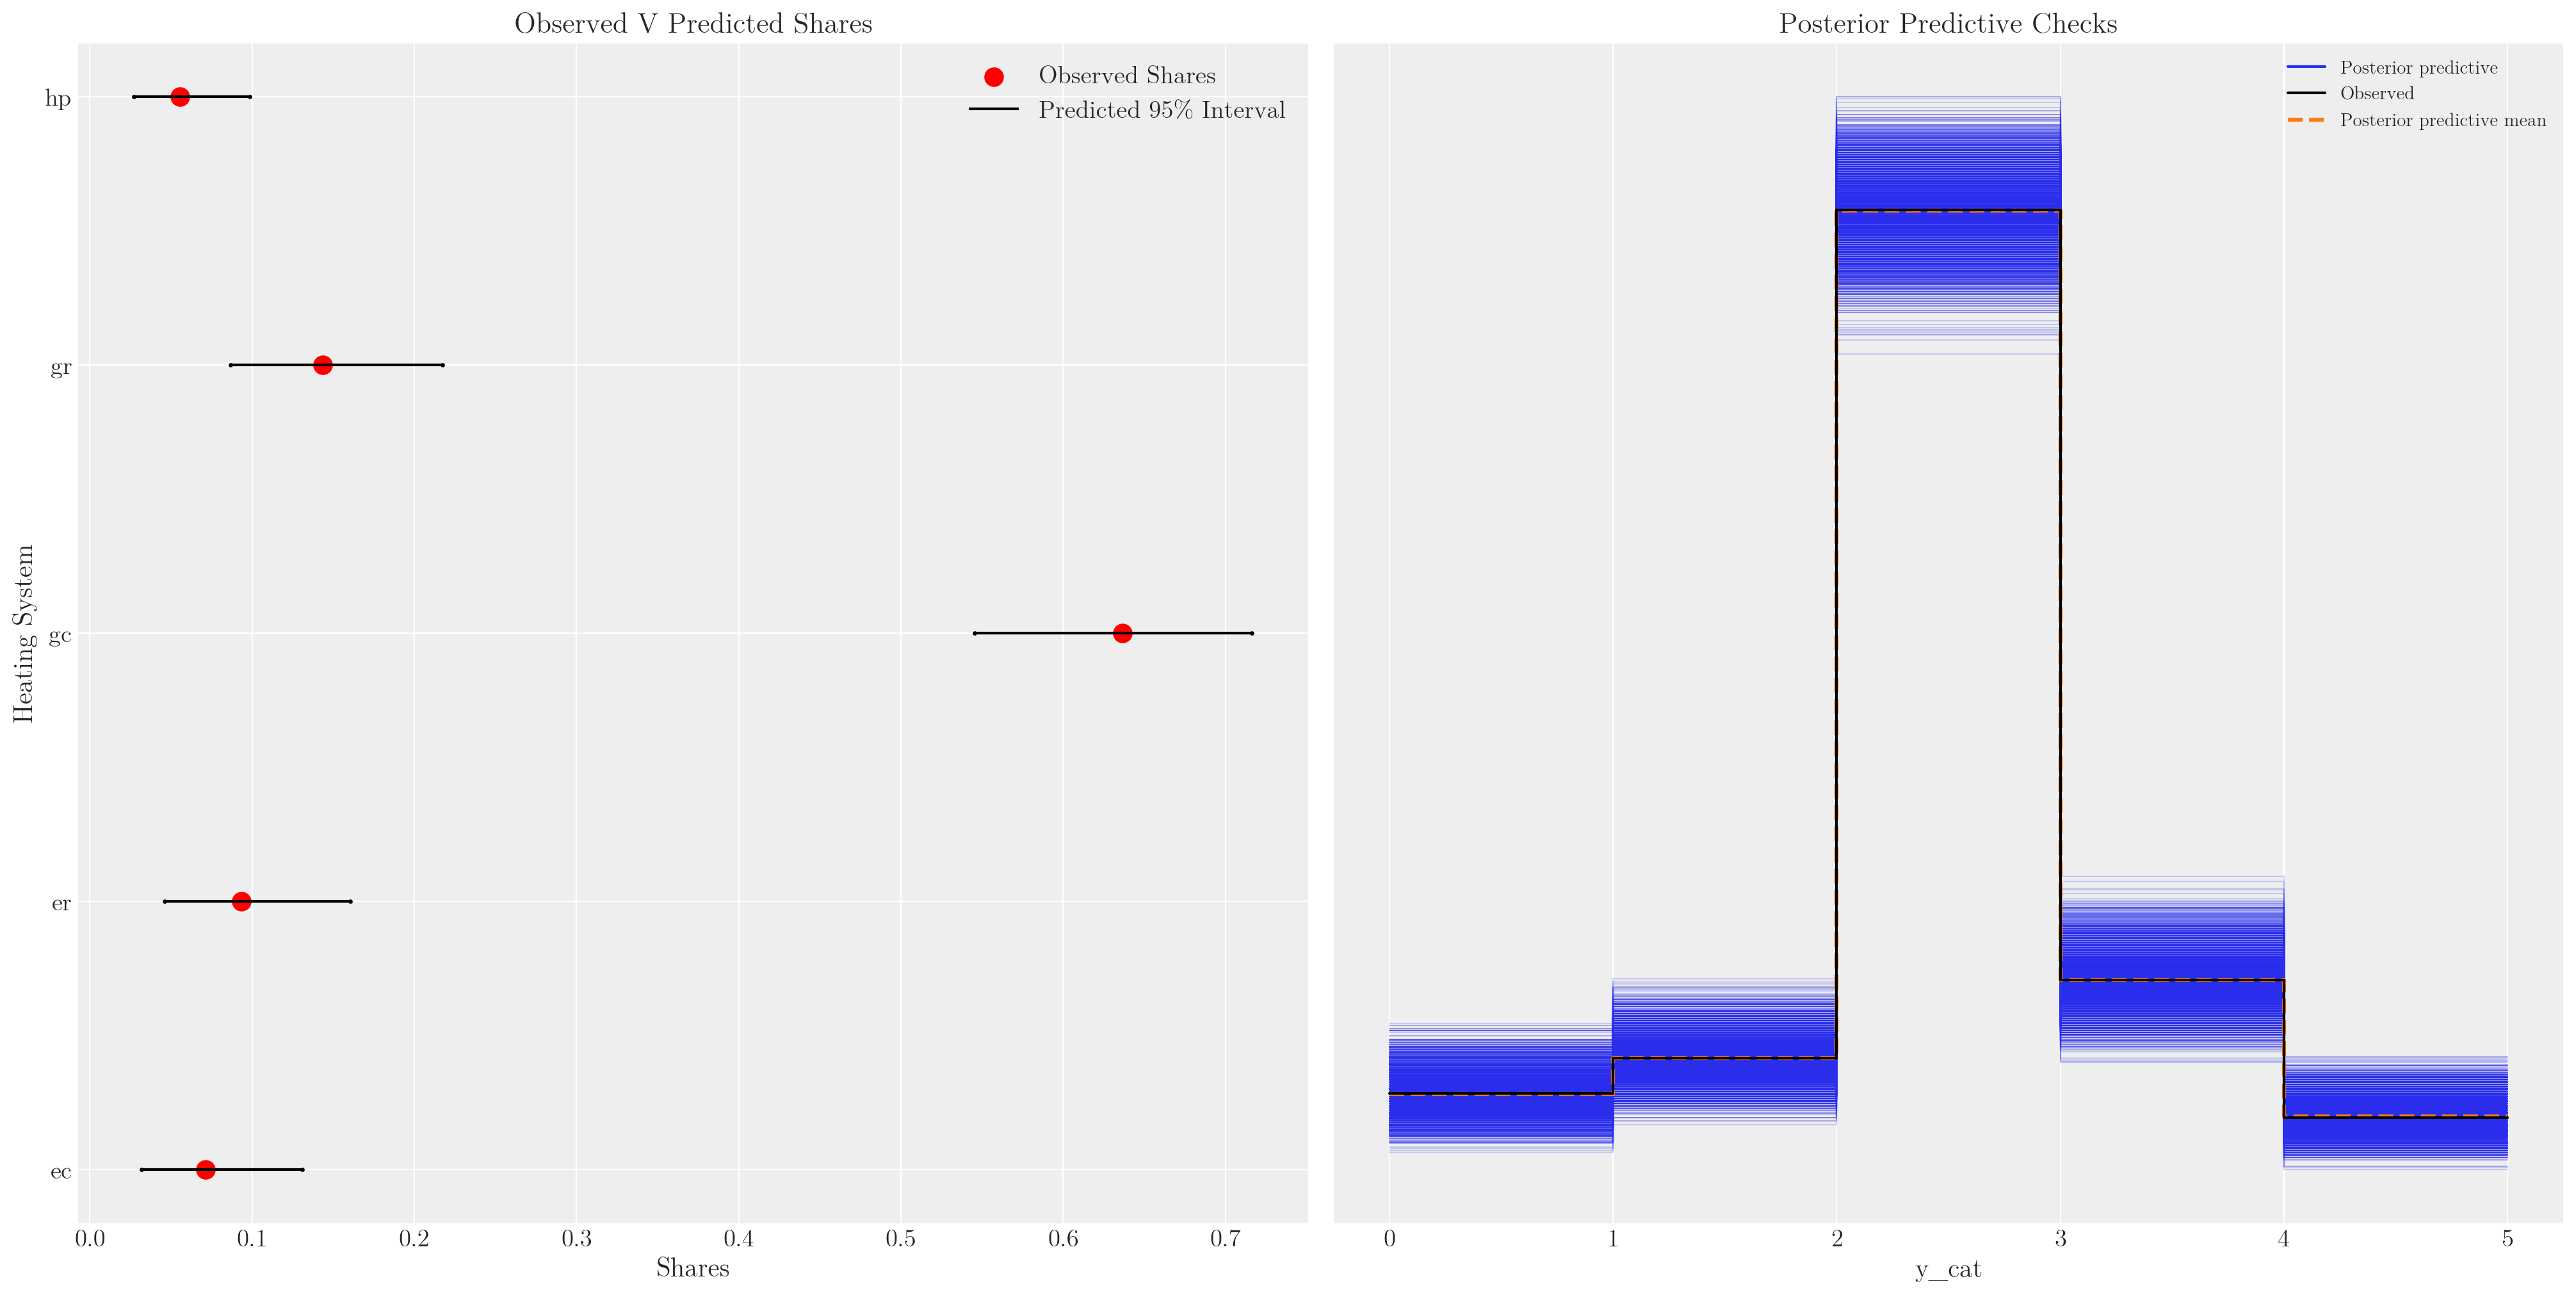

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m4["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m4["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m4["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])

ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m4, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

In [23]:
az.summary(
    idata_m4, var_names=["beta_ic", "beta_oc", "beta_income", "alpha"], round_to=4
)

In [24]:
post = az.extract(idata_m4)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

31.17482352077738

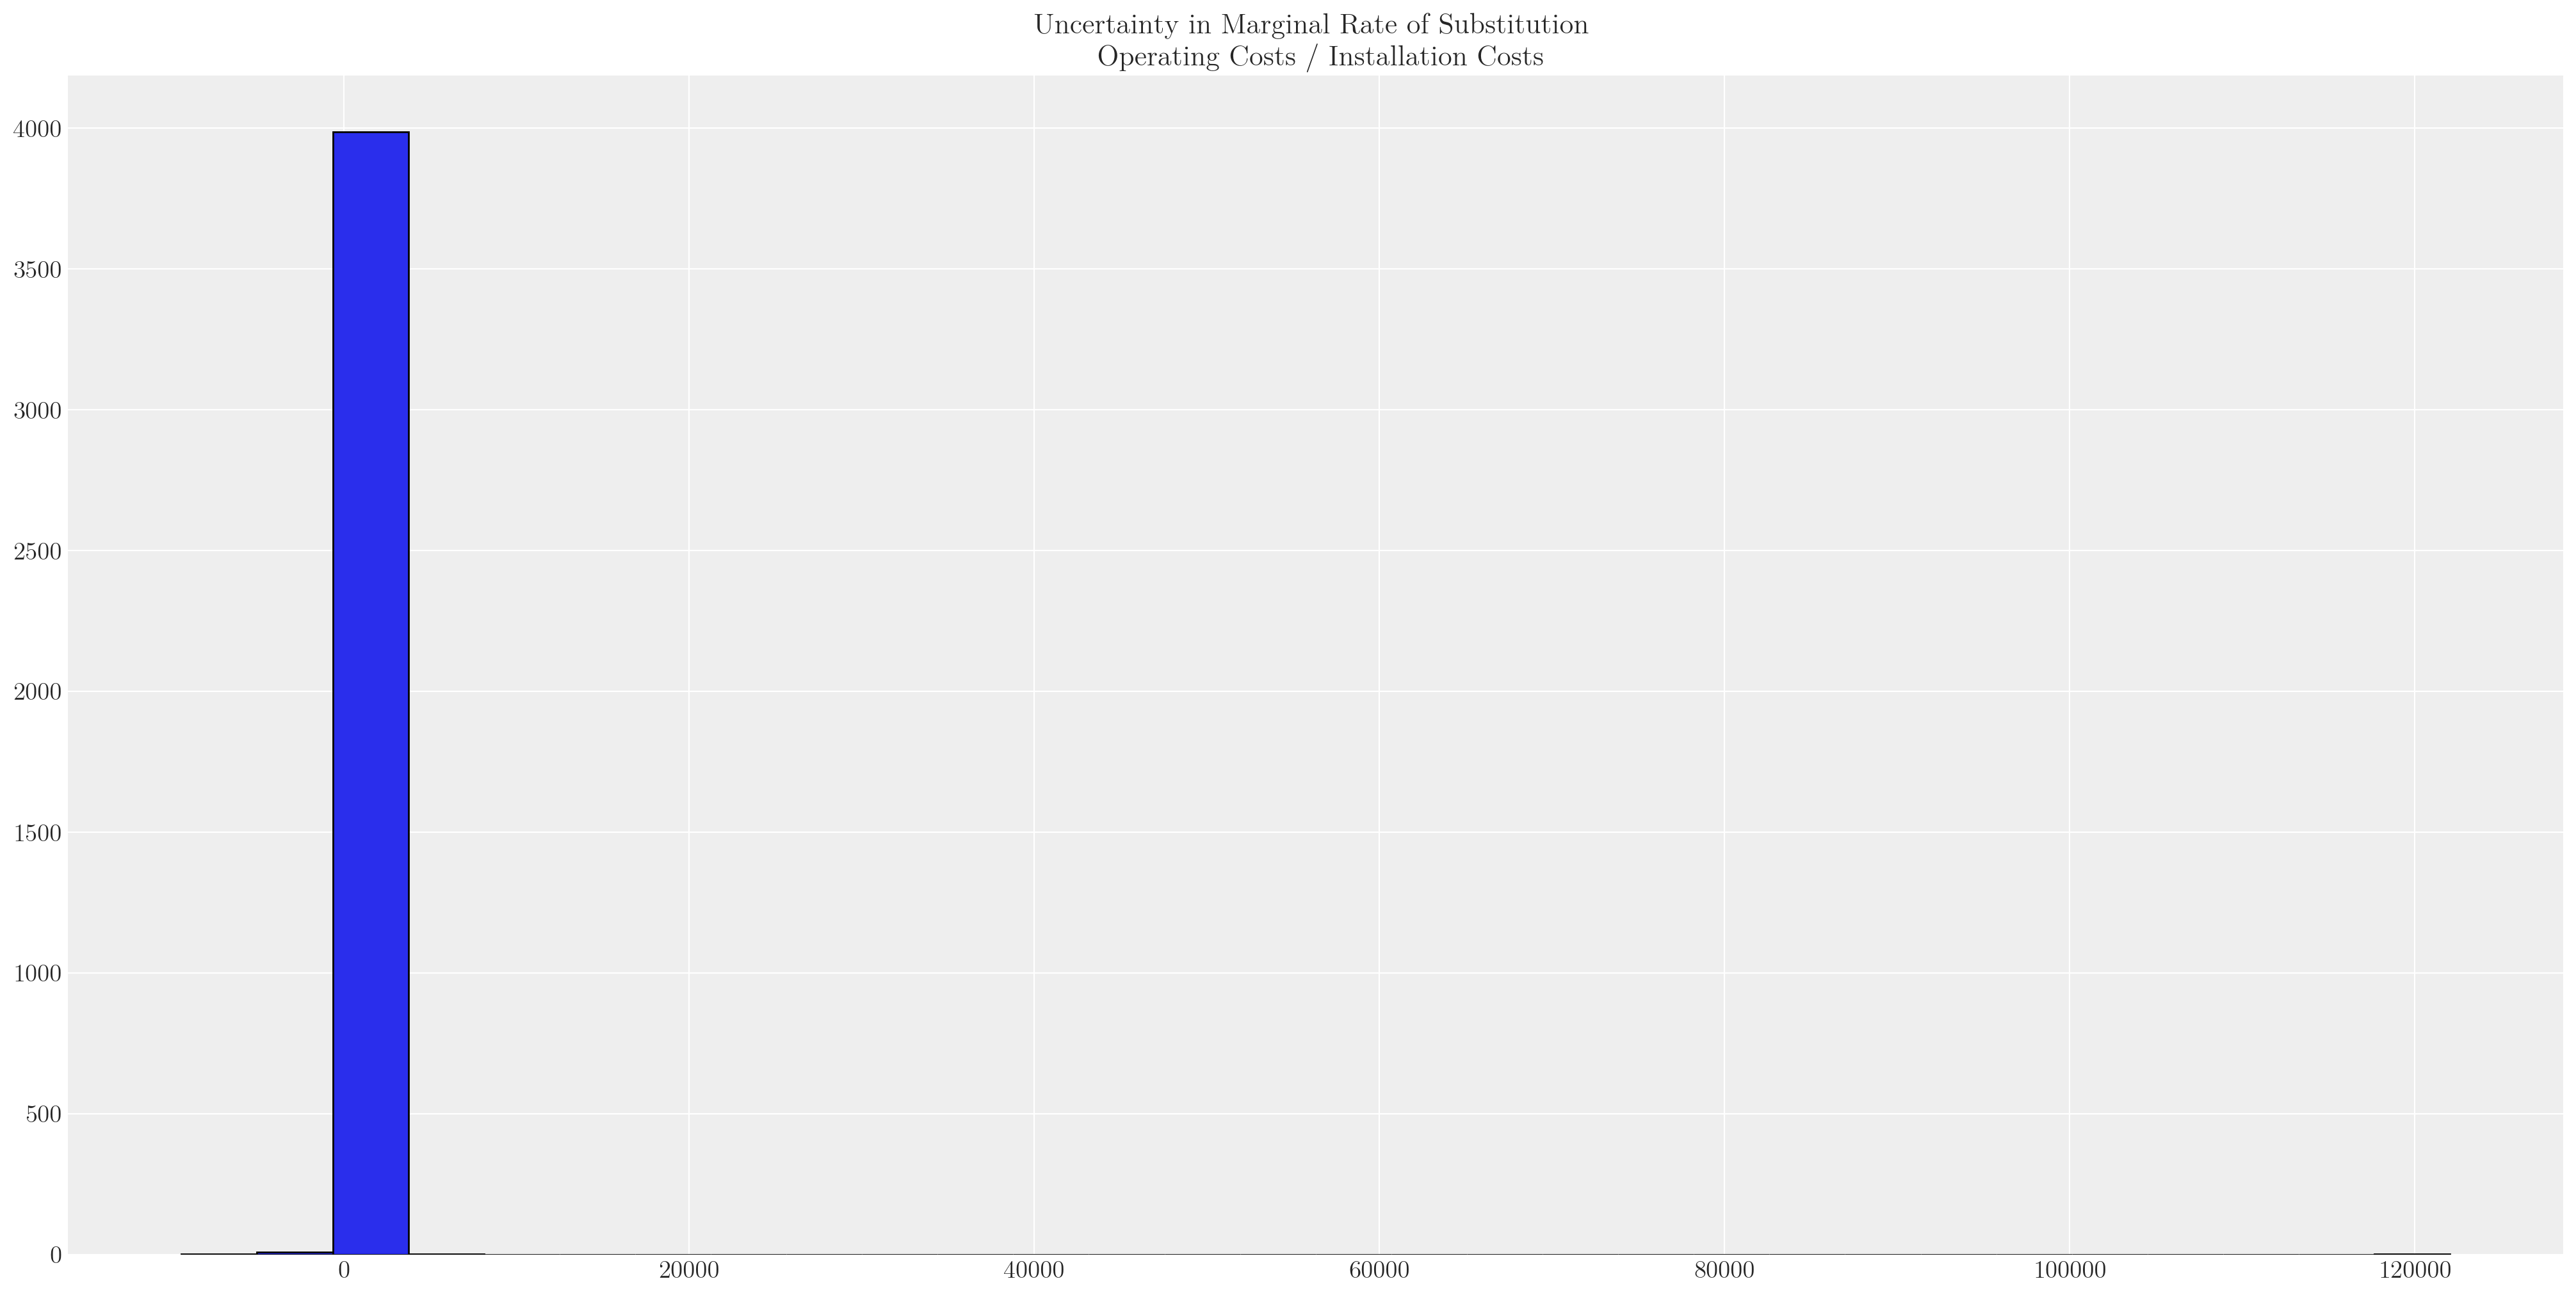

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(
    substitution_rate,
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs");

# Counterfactuals

In [26]:
with model_3:
    # update values of predictors with new 20% price increase in operating costs for electrical options
    pm.set_data({"oc_ec": wide_heating_df["oc.ec"] * 1.2, "oc_er": wide_heating_df["oc.er"] * 1.2})
    # use the updated values and predict outcomes and probabilities:
    idata_new_policy = pm.sample_posterior_predictive(
        idata_m3,
        var_names=["p", "y_cat"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        random_seed=100,
    )

idata_new_policy

Sampling: [y_cat]

arviz.InferenceData 
 
 
 
 
 
 predictions 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset> Size: 173MB
Dimensions: (chain: 4, draw: 1000, obs: 900, alts_probs: 5)
Coordinates:
 * chain (chain) int64 32B 0 1 2 3
 * draw (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
 * obs (obs) int64 7kB 0 1 2 3 4 5 6 7 ... 893 894 895 896 897 898 899
 * alts_probs (alts_probs) <U2 40B 'ec' 'er' 'gc' 'gr' 'hp'
Data variables:
 p (chain, draw, obs, alts_probs) float64 144MB 0.05725 ... 0.04717
 y_cat (chain, draw, obs) int64 29MB 2 4 4 2 1 2 2 2 ... 3 3 2 1 2 4 2
Attributes:
 created_at: 2024-06-23T20:34:06.401295+00:00
 arviz_version: 0.18.0
 inference_library: pymc
 inference_library_version: 5.15.1 xarray.Dataset Dimensions: chain : 4 draw : 1000 obs : 900 alts_probs : 5 Coordinates: (4) chain (chain) int64 0 1 2 3 array([0, 1, 2, 3]) draw (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999 array([ 0, 1, 2, ..., 997, 998, 999]) obs (obs) int64 0 1 2 3 4 5 ... 895 896 897 898 899 array([ 0, 1, 2, ..., 897, 898, 899]) alts_probs (alts_probs) <U2 'ec' 'er' 'gc' 'gr' 'hp' array(['ec', 'er', 'gc', 'gr', 'hp'], dtype='<U2') Data variables: (2) p (chain, draw, obs, alts_probs) float64 0.05725 0.06145 ... 0.1894 0.04717 array([[[[0.05724768, 0.06144754, 0.68573654, 0.12073992, 0.07482832],
 [0.0536941 , 0.06504792, 0.66728469, 0.13613161, 0.07784168],
 [0.06074645, 0.07880667, 0.63082648, 0.15196209, 0.0776583 ],
 ...,
 [0.05956621, 0.07063259, 0.65266042, 0.13936663, 0.07777414],
 [0.06049453, 0.0836567 , 0.63028224, 0.14349363, 0.0820729 ],
 [0.04665807, 0.07612694, 0.61031866, 0.17417927, 0.09271705]],

 [[0.0575523 , 0.05957472, 0.70580507, 0.12394815, 0.05311976],
 [0.04978846, 0.05194444, 0.70624589, 0.13173661, 0.0602846 ],
 [0.05858354, 0.06523037, 0.65436287, 0.15864973, 0.06317349],
 ...,
 [0.0572611 , 0.06067699, 0.67328214, 0.15106374, 0.05771602],
 [0.05613799, 0.08006781, 0.64611688, 0.15639254, 0.06128477],
 [0.03569163, 0.04690307, 0.65923192, 0.18508592, 0.07308747]],

 [[0.03848548, 0.06967034, 0.71777804, 0.11688472, 0.05718142],
 [0.04106635, 0.06133217, 0.70216202, 0.12892532, 0.06651414],
 [0.05499752, 0.08312547, 0.62147335, 0.17002871, 0.07037495],
 ...,
...
 ...,
 [0.05812185, 0.07607232, 0.66578602, 0.14396336, 0.05605645],
 [0.06088941, 0.08638921, 0.64408592, 0.14895731, 0.05967816],
 [0.05234028, 0.06589006, 0.65931254, 0.14420871, 0.07824841]],

 [[0.04946695, 0.04037203, 0.74481053, 0.10060332, 0.06474716],
 [0.05557851, 0.04546533, 0.71803102, 0.10593543, 0.07498971],
 [0.07094328, 0.07473905, 0.60520828, 0.16683318, 0.08227621],
 ...,
 [0.05864539, 0.05887554, 0.64364577, 0.17843161, 0.0604017 ],
 [0.04773015, 0.08160192, 0.63828546, 0.17464675, 0.05773572],
 [0.04628499, 0.05529322, 0.60885068, 0.24491774, 0.04465337]],

 [[0.03588243, 0.06452423, 0.70246049, 0.13061053, 0.06652232],
 [0.04836715, 0.064673 , 0.69243603, 0.12374824, 0.07077557],
 [0.0621403 , 0.08466819, 0.62086437, 0.15856235, 0.07376478],
 ...,
 [0.04919897, 0.07558963, 0.6408676 , 0.17349437, 0.06084943],
 [0.04264316, 0.09181579, 0.6372937 , 0.16979284, 0.05845452],
 [0.06034545, 0.06557241, 0.6375511 , 0.18935961, 0.04717142]]]]) y_cat (chain, draw, obs) int64 2 4 4 2 1 2 2 2 ... 3 3 3 2 1 2 4 2 array([[[2, 4, 4, ..., 3, 2, 2],
 [1, 0, 0, ..., 2, 2, 2],
 [2, 2, 2, ..., 2, 2, 2],
 ...,
 [3, 2, 1, ..., 2, 2, 2],
 [2, 2, 2, ..., 2, 2, 2],
 [0, 2, 2, ..., 2, 2, 2]],

 [[0, 2, 2, ..., 2, 0, 2],
 [2, 0, 2, ..., 2, 0, 1],
 [4, 2, 2, ..., 2, 3, 3],
 ...,
 [2, 2, 2, ..., 2, 2, 2],
 [2, 3, 2, ..., 3, 0, 3],
 [2, 2, 3, ..., 2, 2, 2]],

 [[2, 2, 2, ..., 2, 2, 3],
 [2, 2, 4, ..., 2, 0, 1],
 [2, 0, 4, ..., 2, 4, 3],
 ...,
 [4, 4, 2, ..., 2, 1, 2],
 [2, 4, 1, ..., 2, 2, 2],
 [3, 3, 3, ..., 2, 4, 2]],

 [[2, 2, 3, ..., 2, 2, 2],
 [2, 2, 2, ..., 2, 2, 1],
 [2, 2, 2, ..., 2, 2, 2],
 ...,
 [2, 0, 2, ..., 2, 1, 2],
 [2, 2, 2, ..., 3, 2, 3],
 [2, 3, 1, ..., 2, 4, 2]]]) Indexes: (4) chain PandasIndex PandasIndex(Index([0, 1, 2, 3], dtype='int64

In [27]:
idata_new_policy["predictions"]["p"].mean(dim=["chain", "draw", "obs"])

<xarray.DataArray 'p' (alts_probs: 5)> Size: 40B
array([0.05293203, 0.07065756, 0.66509458, 0.14841689, 0.06289894])
Coordinates:
 * alts_probs (alts_probs) <U2 40B 'ec' 'er' 'gc' 'gr' 'hp' xarray.DataArray 'p' alts_probs : 5 0.05293 0.07066 0.6651 0.1484 0.0629 array([0.05293203, 0.07065756, 0.66509458, 0.14841689, 0.06289894]) Coordinates: (1) alts_probs (alts_probs) <U2 'ec' 'er' 'gc' 'gr' 'hp' array(['ec', 'er', 'gc', 'gr', 'hp'], dtype='<U2') Indexes: (1) alts_probs PandasIndex PandasIndex(Index(['ec', 'er', 'gc', 'gr', 'hp'], dtype='object', name='alts_probs')) Attributes: (0)

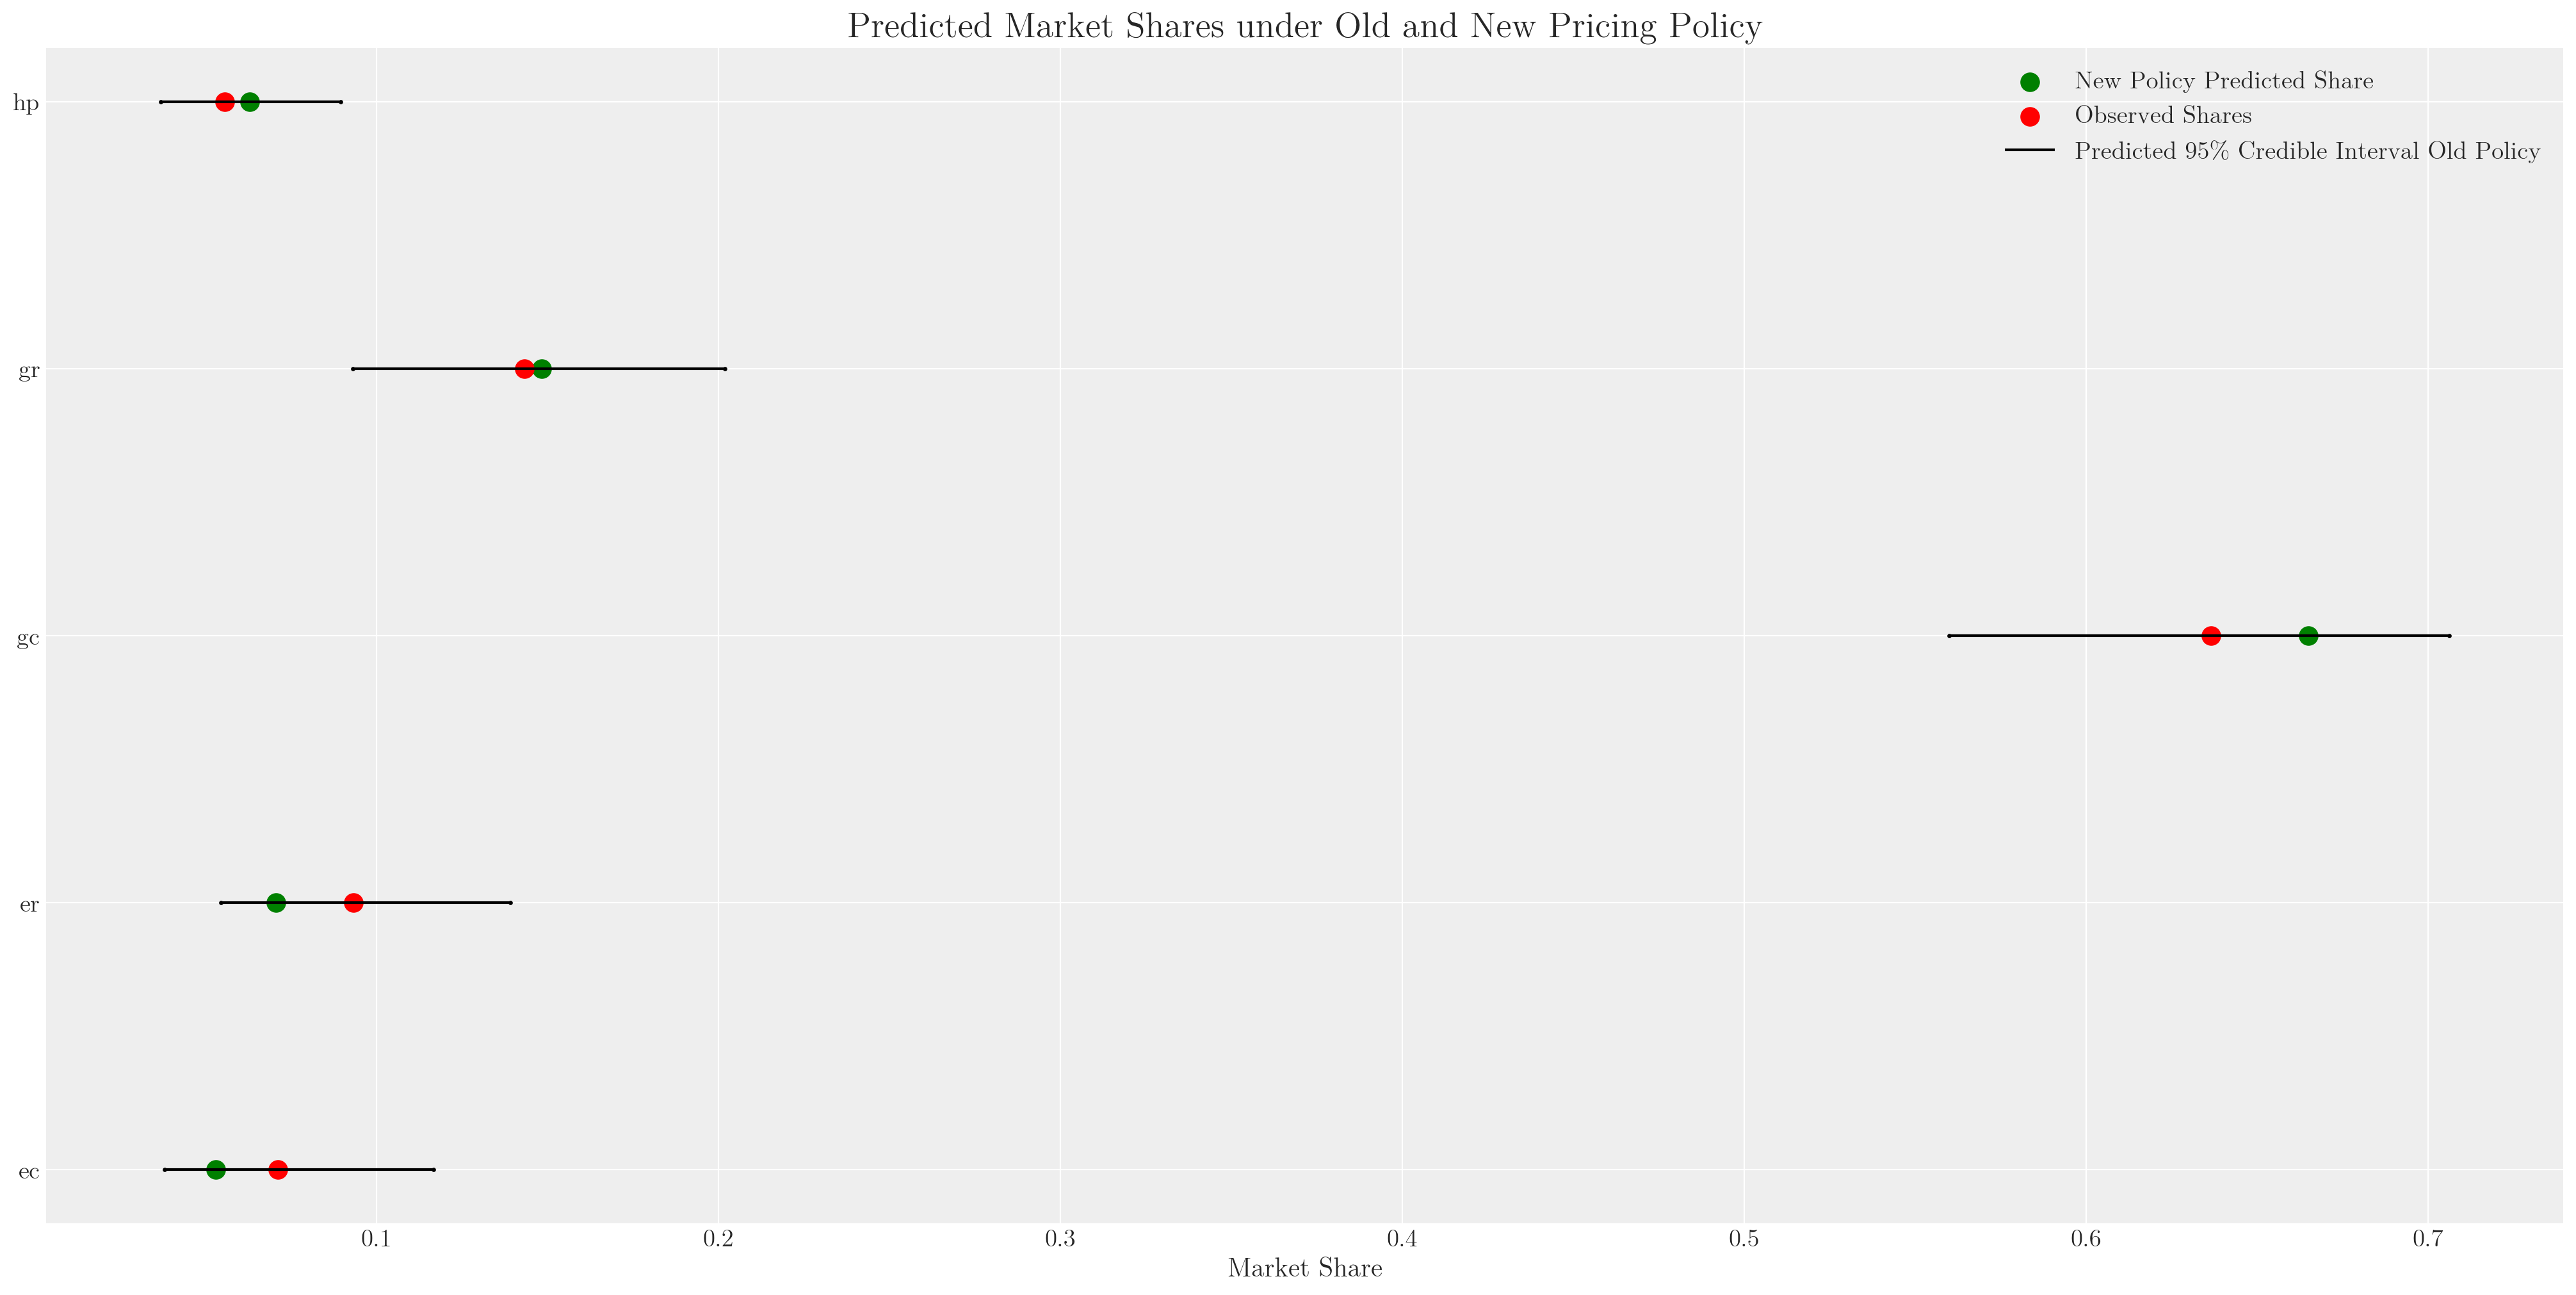

In [28]:
fig, ax = plt.subplots(1, figsize=(20, 10))
counts = wide_heating_df.groupby("depvar")["idcase"].count()
new_predictions = idata_new_policy["predictions"]["p"].mean(dim=["chain", "draw", "obs"]).values
ci_lb = idata_m3["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m3["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    new_predictions,
    ["ec", "er", "gc", "gr", "hp"],
    color="green",
    label="New Policy Predicted Share",
    s=100,
)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"],
    ci_lb,
    ci_ub,
    label="Predicted 95% Credible Interval Old Policy",
    color="black",
)
ax.set_title("Predicted Market Shares under Old and New Pricing Policy", fontsize=20)
ax.set_xlabel("Market Share")
ax.legend();

# Compare models

In [29]:
compare = az.compare({"m1": idata_m1, "m2": idata_m2, "m3": idata_m3, "m4": idata_m4})
compare

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(